In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15,4)

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

from src.visualization.plot import plot, track_plots
ship_data = catalog.load("ship_data")


2022-02-18 14:17:00,642 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-02-18 14:17:02,351 - root - INFO - ** Kedro project wPCC_pipeline
2022-02-18 14:17:02,352 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-02-18 14:17:02,361 - root - INFO - Registered line magic `run_viz`
2022-02-18 14:17:03,459 - kedro.io.data_catalog - INFO - Loading data from `ship_data` (YAMLDataSet)...


### Hold-out
One way to consider the robustness of the VMM:s is to hold-out one of the test types from the training data and then make a prediction on this test type.

In [2]:
def load_join_group_data(join = 'joined', id = 22770):

    
    df_smooth = catalog.load(f"{ id }.data_ek_smooth")
    
    dataframes = {
      'model test' : df_smooth,
    }
    styles = {
        'model test' : {'style':'k-','zorder':10},
    }
    
    colors = ['b','g','r','m','c']
    for vmm in vmms:
        df = catalog.load(f"{ vmm }.motion_regression.{join}.{id}.data_resimulate")
        
        if df['u'].isnull().any():
            continue
            #index = df['u'].isnull().idxmax()
            #df = df.loc[0:index-1].copy()
            
        dataframes[vmm] = df
        if len(colors) > 1:
            color=colors.pop(0)
        else:
            color = colors[0]
            
        styles[vmm] = {'alpha':0.50,'style':f'{color}-'}

    return dataframes,styles

2022-02-18 14:17:03,760 - kedro.io.data_catalog - INFO - Loading data from `22774.data_ek_smooth` (CSVDataSet)...
2022-02-18 14:17:03,804 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:03,837 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_simple.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:03,870 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:03,904 - kedro.io.data_catalog - INFO - Loading data from `vmm_linear.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:03,937 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:03,970 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_expanded.motion_regress

2022-02-18 14:17:04,297 - kedro.io.data_catalog - INFO - Loading data from `22774.data_ek_smooth` (CSVDataSet)...
2022-02-18 14:17:04,345 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:04,364 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_simple.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:04,383 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:04,404 - kedro.io.data_catalog - INFO - Loading data from `vmm_linear.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:04,437 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.no_circle.22774.data_resimulate` (CSVDataSet)...
2022-02-18 14:17:04,468 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_expanded

DataSetError: Failed while loading data from data set CSVDataSet(filepath=E:/dev/wPCC_pipeline/data/07_model_output/vmm_abkowitz_expanded/motion_regression/no_circle/vmm_abkowitz_expanded.motion_regression.no_circle.22774.data_resimulate.csv, load_args={'index_col': 0}, protocol=file, save_args={'index': True}).
[Errno 2] No such file or directory: 'E:/dev/wPCC_pipeline/data/07_model_output/vmm_abkowitz_expanded/motion_regression/no_circle/vmm_abkowitz_expanded.motion_regression.no_circle.22774.data_resimulate.csv'

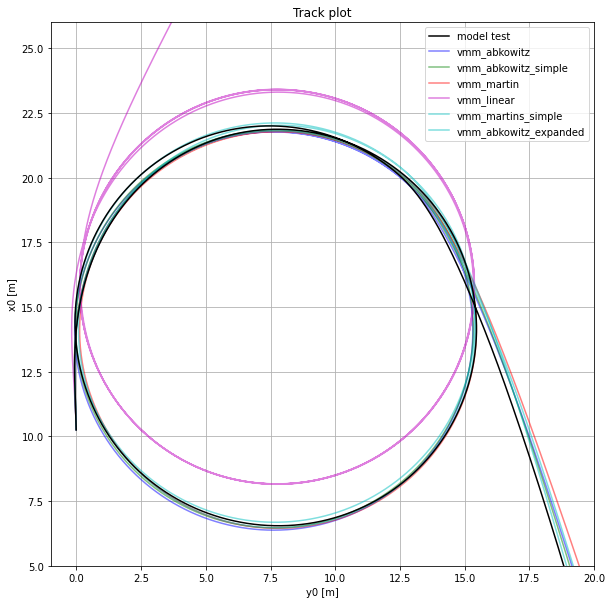

In [3]:
id = 22774

keys=['psi','u','v','r']
dataframes, styles = load_join_group_data(join = 'joined', id=id)
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plots(dataframes, styles=styles, lpp=ship_data['L'], beam=ship_data['B'], N=7, plot_boats=False, ax=ax);
fig.axes[0].set_xlim(-1,20)
fig.axes[0].set_ylim(5,26)
glue("fig_joined", fig, display=False)

dataframes, styles_ = load_join_group_data(join = 'no_circle', id=id)
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
track_plots(dataframes, styles=styles, lpp=ship_data['L'], beam=ship_data['B'], N=7, plot_boats=False, ax=ax);
fig.axes[0].set_xlim(-1,20)
fig.axes[0].set_ylim(5,26)
glue("fig_no_circle", fig, display=False)


{numref}`fig_joined` shows the track plots from the turning circle model test and simulations with the VMM:s. The VMM:s have been trained on all the model tests and it can be seen that all of the VMM:s, except the linear model, is in good agreement with the model test. 

Corresponding simulations have also been conducted with VMM:s where the turning circle test has been exluded from the training set (hold-out). Result from these simulations can be seen in {numref}`fig_no_circle`. Only two of the simpler models were able to complete the simulations for this case. Simulations with these models also have less agreement with the model tests then before.


```{glue:figure} fig_joined
:figwidth: 600px
:name: "fig_joined"

Predictions of turning circle with VMM:s trained on all model tests.
```

```{glue:figure} fig_no_circle
:figwidth: 600px
:name: "fig_no_circle"

Predictions of turning circle with VMM:s trained on turning circle as hold out.
```

In [ ]:
def load_accuracies():
    
    regression = "motion_regression"
    
    df_rmse = pd.DataFrame() 
    
    for vmm in vmms:
        
        for join in joins:
        
            for id in model_test_ids:
    
                rmse = catalog.load(f"{ vmm }.{ regression }.{ join }.{ id }.online_prediction_rmse")
                
                
                rmse["vmm"] = vmm
                rmse["join"] = join
                rmse["model_test_id"] = int(id)
                df_rmse = df_rmse.append(rmse, ignore_index=True)
                
    #rmse["model_test_id"] = rmse["model_test_id"].astype(int)
    return df_rmse

In [ ]:
df_rmse = load_accuracies()

```{glue:figure} fig_no_circle_A_FP_rmse
:figwidth: 600px
:name: "fig_no_circle_A_FP_rmse"

RMSE of the total acceleration errors for all the VMM:s and turning circle as hold out test type.
```

In [ ]:
hold_outs = {

    'no_circle' : [22774,], 
    'no_ZZ10' : [22764,22769,22770,],
    'no_ZZ20' : [22771,22772,22773,],

}

In [ ]:
def hold_out_prediction_error(group,hold_outs):
    
    join = group.iloc[0]['join']
    
        
    hold_out_test_ids = hold_outs[join]
    
    mask = group['model_test_id'].isin(hold_out_test_ids)
    hold_out_tests = group.loc[mask]
    mean_error = hold_out_tests['A_FP'].mean()
    
    return float(mean_error)
    
    

In [ ]:
mask = df_rmse['join']!='joined'
df_rmse_hold_outs = df_rmse.loc[mask].copy()

df_hold_outs = df_rmse_hold_outs.groupby(['vmm','join']).apply(hold_out_prediction_error, hold_outs=hold_outs).reset_index().rename(columns={0:'A_FP'})

In [ ]:
fig,ax=plt.subplots()
df_hold_outs.pivot(index='join', columns='vmm').plot.bar(y='A_FP', ax=ax);
ax.set_ylim(0,df_hold_outs['A_FP'].max())
glue("fig_hold_outs", fig, display=False)

In [ ]:
joined_group = df_rmse.groupby(by='join').get_group('joined')
df_ref = pd.DataFrame()

refs = {f"{key[3:]}": value for key, value in hold_outs.items()}

for vmm, group in joined_group.groupby('vmm'):
    for join, hold_out_test_ids in refs.items():
        
        mask = group['model_test_id'].isin(hold_out_test_ids)
        hold_out_tests = group.loc[mask]
        mean_error = hold_out_tests['A_FP'].mean()
        s = pd.Series()
        s['A_FP'] = mean_error
        s['vmm'] = vmm
        s['join'] = join
        df_ref = df_ref.append(s, ignore_index=True)
        

In [ ]:
fig,ax=plt.subplots()
df_ref.pivot(index='join', columns='vmm').plot.bar(y='A_FP', ax=ax);
ax.set_ylim(0,df_hold_outs['A_FP'].max())
glue("fig_ref", fig, display=False)

The same procedure can also be applied with ZigZag10/10 as hold-out and ZigZag20/20 as hold-out. As a reference, the accuracy for ZigZag10/10, ZigZag20/20 and turning circle from all VMM:s trained on all data is showed in {numref}`fig_ref`. How the accuracy of these test types change with hold-out-tests is shown in {numref}`fig_hold_outs`. 

```{glue:figure} fig_ref
:figwidth: 1000px
:name: "fig_ref"

RMSE for ZigZag10/10, ZigZag20/20 and turning circle, for all the VMM:s trained on all model tests.
```

```{glue:figure} fig_hold_outs
:figwidth: 1000px
:name: "fig_hold_outs"

RMSE of the total acceleration errors for all the VMM:s trained with ZigZag10/10, ZigZag20/20 and turning circle as hold out tests type.
```
All of the VMM:s seem to work for the ZigZag10/10 and 20/20 hold-out tests. The accuracy is not decreased much for these cases, compared to the reference. The ZigZag10/10 hold-out has slightly better accuracy than ZigZag20/20 hold-out for all VMM:s. In other words: predicting a ZigZag10/10 from a 20/20 model test gives better accuracy than the reversed scenario.

The more complex models, such as the Abkowitz model, have poor accuracy for the Turning circle hold-out, which can even mean that they are not possible to simulate as seen in the begining of this section. 